# 0. Reading the Brute Raw Data

This notebook contains the code for reading the "brute" raw data, which are essentially Digital Elevation Models of the area of interest in this project.

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.plot
from osgeo import gdal
from rasterio import plot, mask, Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.windows import Window
import matplotlib.pyplot as plt
import rasterstats
import rioxarray
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
pwd

'/home/jovyan/nz-landslides/notebooks'

In [3]:
dem16_fn = '/home/jovyan/nz-landslides_local/0-brute-raw-data/dem/2016.tif'
dem17_fn = '/home/jovyan/nz-landslides_local/0-brute-raw-data/dem/2017.tif'
dem18_fn = '/home/jovyan/nz-landslides_local/0-brute-raw-data/dem/2018.tif'

In [4]:
src16 = rio.open(dem16_fn)
src17 = rio.open(dem17_fn)
src18 = rio.open(dem18_fn)

dems = [src16, src17, src18]
lbls = ['2016', '2017', '2018']

In [5]:
for dem, i in zip(dems, lbls):
    print(i+':')
    print(dem.meta)
    print()

2016:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 9998, 'height': 9360, 'count': 1, 'crs': CRS.from_epsg(2193), 'transform': Affine(1.0, 0.0, 1660960.0,
       0.0, -1.0, 5327520.0)}

2017:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 10425, 'height': 10028, 'count': 1, 'crs': CRS.from_epsg(2120), 'transform': Affine(1.0, 0.0, 395075.2848,
       0.0, -1.0, 726504.6995)}

2018:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 10425, 'height': 10028, 'count': 1, 'crs': CRS.from_epsg(2120), 'transform': Affine(1.0, 0.0, 395075.2848,
       0.0, -1.0, 726504.6995)}



In [6]:
for dem, i in zip(dems, lbls):
    print(i+':')
    print(dem.profile)
    print()

2016:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 9998, 'height': 9360, 'count': 1, 'crs': CRS.from_epsg(2193), 'transform': Affine(1.0, 0.0, 1660960.0,
       0.0, -1.0, 5327520.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

2017:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 10425, 'height': 10028, 'count': 1, 'crs': CRS.from_epsg(2120), 'transform': Affine(1.0, 0.0, 395075.2848,
       0.0, -1.0, 726504.6995), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

2018:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 10425, 'height': 10028, 'count': 1, 'crs': CRS.from_epsg(2120), 'transform': Affine(1.0, 0.0, 395075.2848,
       0.0, -1.0, 726504.6995), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}



In [7]:
for dem, i in zip(dems, lbls):
    print(i+':')
    print(dem.crs)
    print()

2016:
EPSG:2193

2017:
EPSG:2120

2018:
EPSG:2120



In [8]:
ma16 = src16.read(1, masked=True)
ma17 = src17.read(1, masked=True)
ma18 = src18.read(1, masked=True)

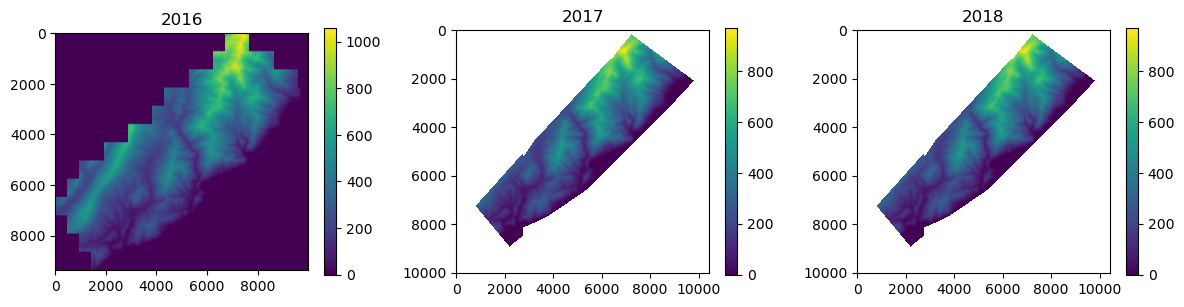

In [9]:
f, ax = plt.subplots(1,3, figsize=(12, 3))
im = ax[0].imshow(ma16)
ax[0].set_title(lbls[0])
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(ma17)
ax[1].set_title(lbls[1])
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(ma18)
ax[2].set_title(lbls[2])
f.colorbar(im, ax=ax[2])
plt.tight_layout()

In [10]:
ma16.shape

(9360, 9998)

In [11]:
ma17.shape

(10028, 10425)

In [17]:
ma17.mean()

266.79140056039785

In [18]:
ma18.mean()

266.79140056039785

In [12]:
ma18.shape

(10028, 10425)

In [13]:
path = '/home/jovyan/nz-landslides_local/0-brute-raw-data/dem/'
dems_fn = [dem16_fn, dem17_fn, dem18_fn]
output_fn = ['2016_utm.tif', '2017_utm.tif', '2018_utm.tif']

for fn, i in zip(dems_fn, output_fn):
    # Input and output file paths
    input_raster_path = fn
    output_raster_path = path+i
    
    # Define the target CRS (coordinate reference system) you want to project to
    target_crs = CRS.from_epsg(32759)  #WGS 84 / UTM zone 59S
    
    # Open the input raster file
    with rio.open(input_raster_path) as src:
        # Retrieve metadata
        src_transform = src.transform
        src_crs = src.crs
        src_data = src.read()
        nodata_value = src.nodata  # Get the nodata value from the source raster
    
        # Define the transform and dimensions of the reprojected raster
        dst_transform, dst_width, dst_height = calculate_default_transform(src_crs, 
                                                                           target_crs, 
                                                                           src.width, 
                                                                           src.height, 
                                                                           *src.bounds)
    
        # Update metadata for the reprojected raster
        dst_meta = src.meta.copy()
        dst_meta.update({
            'crs': target_crs,
            'transform': dst_transform,
            'width': dst_width,
            'height': dst_height,
            'nodata': 0.0  # Set the nodata value to 0.0 in the metadata
        })
    
        # Create an output raster file
        with rio.open(output_raster_path, 'w', **dst_meta) as dst:
            # Reproject the raster
            reproject(
                source=rio.band(src, 1),
                destination=rio.band(dst, 1),
                src_transform=src_transform,
                src_crs=src_crs,
                dst_transform=dst_transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear,  # You can change the resampling method as per your preference
                src_nodata=nodata_value,  # Specify the source nodata value
                dst_nodata=0.0  # Set the destination nodata value to 0.0
            )
    
    print("Reprojection and saving of '{}' completed.".format(i))

Reprojection and saving of '2016_utm.tif' completed.
Reprojection and saving of '2017_utm.tif' completed.
Reprojection and saving of '2018_utm.tif' completed.


In [14]:
dem16_utm_fn = '/home/jovyan/nz-landslides_local/0-brute-raw-data/dem/2016_utm.tif'
dem17_utm_fn = '/home/jovyan/nz-landslides_local/0-brute-raw-data/dem/2017_utm.tif'
dem18_utm_fn = '/home/jovyan/nz-landslides_local/0-brute-raw-data/dem/2018_utm.tif'

src_utm_16 = rio.open(dem16_utm_fn)
src_utm_17 = rio.open(dem17_utm_fn)
src_utm_18 = rio.open(dem18_utm_fn)

dems = [src_utm_16, src_utm_17, src_utm_18]
lbls = ['2016', '2017', '2018']

for dem, i in zip(dems, lbls):
    print(i+':')
    print(dem.profile)
    print()

2016:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 10215, 'height': 9592, 'count': 1, 'crs': CRS.from_epsg(32759), 'transform': Affine(1.0006031130830697, 0.0, 725858.5712655482,
       0.0, -1.0006031130830697, 5324153.214373582), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

2017:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 10749, 'height': 10365, 'count': 1, 'crs': CRS.from_epsg(32759), 'transform': Affine(1.0002590619872282, 0.0, 726055.9057787666,
       0.0, -1.0002590619872282, 5323696.329347556), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

2018:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 10749, 'height': 10365, 'count': 1, 'crs': CRS.from_epsg(32759), 'transform': Affine(1.0002590619872282, 0.0, 726055.9057787666,
       0.0, -1.0002590619872282, 5323696.329347556), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}



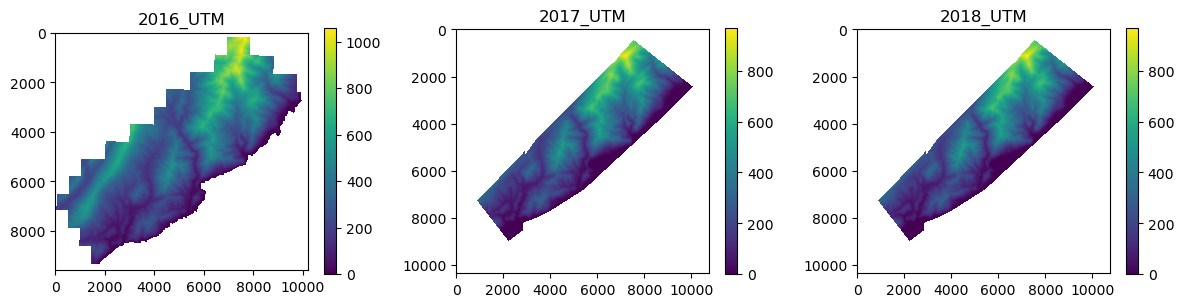

In [15]:
f, ax = plt.subplots(1,3, figsize=(12, 3))
im = ax[0].imshow(src_utm_16.read(1, masked=True))
ax[0].set_title(lbls[0]+'_UTM')
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(src_utm_17.read(1, masked=True))
ax[1].set_title(lbls[1]+'_UTM')
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(src_utm_18.read(1, masked=True))
ax[2].set_title(lbls[2]+'_UTM')
f.colorbar(im, ax=ax[2])
plt.tight_layout()